In [1]:
import datetime
import json
import math
import os
import pytz
import random
import re

from functools import reduce, partial
from joblib import Memory
from tempfile import mkdtemp
from typing import List

import nltk
import numpy as np
import pandas as pd
import umap.umap_ as umap
import umap.plot

import emoji
from matplotlib import pyplot as plt
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import preprocessing, metrics
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, 
                             auc,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             f1_score, 
                             precision_score, 
                             RocCurveDisplay,
                             recall_score, 
                             roc_curve, 
                            )
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.utils.extmath import randomized_svd
from textblob import TextBlob
from tqdm.auto import tqdm

2023-03-08 05:24:10.162455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 05:24:10.287148: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-9.0/lib64:/usr/local/cuda-9.0/lib64:
2023-03-08 05:24:10.287187: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-08 05:24:11.227962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfe

In [2]:
SEED = 806
np.random.seed(SEED)
# plt.style.use("seaborn-bright")
random.seed(SEED)

/tmp/ipykernel_27643/3554118125.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-bright")


In [30]:
SEED = 806
np.random.seed(SEED)
# plt.style.use("seaborn-bright")
random.seed(SEED)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
# plt.rcParams['text.usetex'] = True
plt.rcParams.update({
#     "text.usetex": True,
    "font.family": "monospace"
})
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

colors = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']


plt.rcParams[u'figure.figsize'] = [12, 8]
plt.rcParams[u'figure.dpi'] = 300

In [3]:
game_start = 1422833400
game_end = 1422845700

In [4]:
import pytz
pst_tz = pytz.timezone('America/Los_Angeles')
datetime_object_in_pst_timezone = datetime.datetime.fromtimestamp(game_start, pst_tz)
datetime_object_in_pst_timezone

datetime.datetime(2015, 2, 1, 15, 30, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>)

In [5]:
import pytz
pst_tz = pytz.timezone('America/Los_Angeles')
datetime_object_in_pst_timezone = datetime.datetime.fromtimestamp(game_end, pst_tz)
datetime_object_in_pst_timezone

datetime.datetime(2015, 2, 1, 18, 55, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>)

In [6]:
data_dir = "/tmp2/kch/ece219/ECE219_tweet_data"
filename = "tweets_#superbowl.txt"
data = []
n = 100

with open(os.path.join(data_dir, filename)) as f:
    for line in tqdm(f):
        all_info = json.loads(line)
        # print(all_info.keys())
        # print(all_info["tweet"]["user"])
        taken_info = {
            "type": all_info["type"],
            # "title": all_info["title"],
            "text": all_info["tweet"]["text"],
            "id": all_info["tweet"]["id"],
            "hashtags": " ".join([
                " ".join([s for s in re.split('([A-Z][a-z]+)', h["text"]) if s]) 
                for h in all_info["tweet"]["entities"]["hashtags"]
            ]),  # hashtag split
            "location": all_info["tweet"]["user"]['location'],
            "citation_date": all_info["citation_date"],
        }
        if taken_info["citation_date"] > game_end:
            continue
        if taken_info["citation_date"] <= game_start or taken_info["text"] == "":
            continue
        data.append(taken_info)

data_df = pd.DataFrame(data)

0it [00:00, ?it/s]

In [7]:
data_df['citation_date_datetime'] = data_df['citation_date'].apply(datetime.datetime.fromtimestamp, args=(pst_tz,))

In [8]:
def tweets_per_minute(df: pd.DataFrame):
    return df[['text']].groupby([df['citation_date_datetime'].dt.date, 
                                  df['citation_date_datetime'].dt.hour,
                                  df['citation_date_datetime'].dt.minute,
                                 ]).count()

In [9]:
import matplotlib.colors as mcolors

def tweets_per_minute_plot(df: pd.DataFrame, title_prefix="", sample_freq=10):
    
    group_df = tweets_per_minute(df)
    fig = plt.figure(figsize = (10, 5))

    cmap = mcolors.LinearSegmentedColormap.from_list("", ["gold", "gold", "green", "darkblue"])

    plt.bar([f"{x[0]} {x[1]}H {x[2]}M" for x in group_df.index], 
            group_df.melt()['value'],
            width=1,
            color=cmap(group_df.melt()['value']/group_df.melt()['value'].max())
           )
    max_value = (max(group_df.melt()['value']))
    
    scoring_timestamp = [1422835905, 1422837178, 1422838078, 1422838706, 1422840875, 1422842032, 1422844038, 1422845270]

    for idx, timestamp in enumerate(scoring_timestamp):
        dt = datetime.datetime.fromtimestamp(timestamp, pst_tz)
        plt.axvline(list(group_df.index).index((dt.date(), dt.hour, dt.minute)), color="red", linestyle='--')
        plt.text(list(group_df.index).index((dt.date(), dt.hour, dt.minute))+5, 
                 max_value+1, str(idx+1), 
                 fontsize=10,
                 ha="center", 
                 va="center",
                 bbox = dict(boxstyle=f"circle,pad={0.2}", fc="white", color="red"), color="red")

    plt.xticks(np.arange(0, len(group_df.index), step=sample_freq), 
               [f"{x[0]} {x[1]}H {x[2]}M" for x in group_df.index][::sample_freq], 
               rotation=90)
    plt.xlabel("Citation Datetime")
    plt.ylabel("Number of Tweets")
    #plt.title(f"Number of #{title_prefix} tweets in a minute with the scoring time point (red)")
    plt.show()

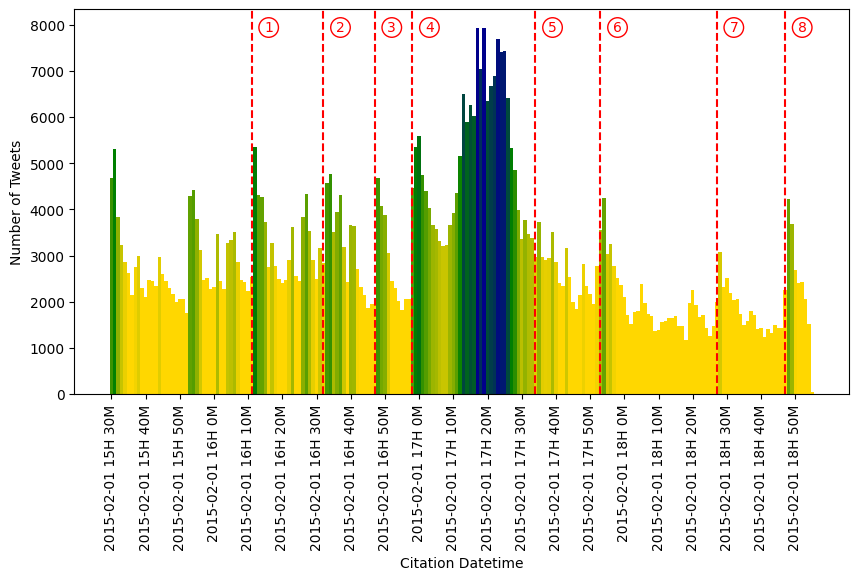

In [10]:
tweets_per_minute_plot(data_df, title_prefix="Super Bowl")

In [11]:
def read_file(filename: str):
    data_dir = "/tmp2/kch/ece219/ECE219_tweet_data"
    data = []
    n = 100

    with open(os.path.join(data_dir, filename)) as f:
        for line in tqdm(f):
            all_info = json.loads(line)
            taken_info = {
                "type": all_info["type"],
                "title": all_info["title"],
                "text": all_info["tweet"]["text"],
                "id": all_info["tweet"]["id"],
                "hashtags": [
                    h["text"].lower() for h in all_info["tweet"]["entities"]["hashtags"]
                ],
                "retweet_count": all_info["tweet"]["retweet_count"],
                "author_followers": all_info["author"]["followers"],
                "original_author_followers": all_info["original_author"]["followers"],
                "citation_date": all_info["citation_date"],
                "ranking_score": all_info["metrics"]["ranking_score"],
                "citations": all_info["metrics"]["citations"]["total"],
                "impressions": all_info["metrics"]["impressions"],
            }
            data.append(taken_info)
    #         if len(data) == n:
    #             break

    data_df = pd.DataFrame(data)
    data_df['citation_date_datetime'] = data_df['citation_date'].apply(datetime.datetime.fromtimestamp, args=(pst_tz,))
    return data_df
    
def get_filepaths(rootdir: str):
    res = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            filepath = subdir + os.sep + file
            if filepath.endswith(".txt"):
                res.append(filepath)
    return res
    
def file_statistics(df: str):
    pst_tz = pytz.timezone('America/Los_Angeles')
    df['citation_date_datetime'] = df['citation_date'].apply(datetime.datetime.fromtimestamp, args=(pst_tz,))
    max_citation_date = max(df['citation_date_datetime'])
    min_citation_date = min(df['citation_date_datetime'])
    
    avg_tweets_per_hour = len(df) / ((max_citation_date - min_citation_date).total_seconds() / 60 / 60)
    avg_followers_posting_tweets = df['citations'].sum() / len(df)
    avg_retweet_per_tweet = df['author_followers'].sum() / len(df)

    print(f'Average tweets per minute: {avg_tweets_per_hour}')    
    print(f'Average number of users posting tweets per tweet: {avg_followers_posting_tweets}')
    print(f'Average number of retweet per tweet: {avg_retweet_per_tweet}')

In [12]:
rootdir = "/tmp2/kch/ece219/ECE219_tweet_data"
dataset = {}

filepaths = get_filepaths(rootdir)
dataset_dict = {filepath: read_file(filepath) for filepath in filepaths}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp2/kch/ece219/ECE219_tweet_data/tweets_#superbowl.txt


/tmp/ipykernel_27643/2362341121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citation_date_datetime'] = df['citation_date'].apply(datetime.datetime.fromtimestamp, args=(pst_tz,))


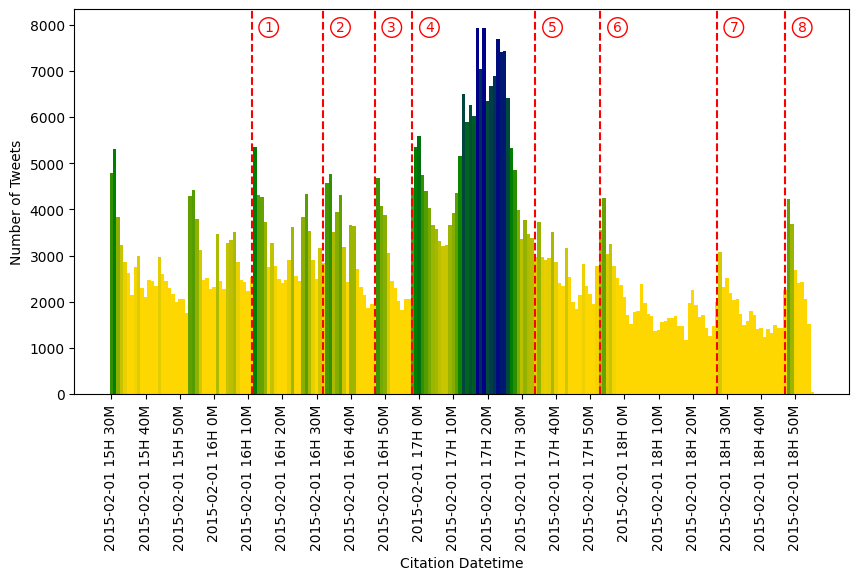

/tmp2/kch/ece219/ECE219_tweet_data/tweets_#sb49.txt


/tmp/ipykernel_27643/2362341121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citation_date_datetime'] = df['citation_date'].apply(datetime.datetime.fromtimestamp, args=(pst_tz,))


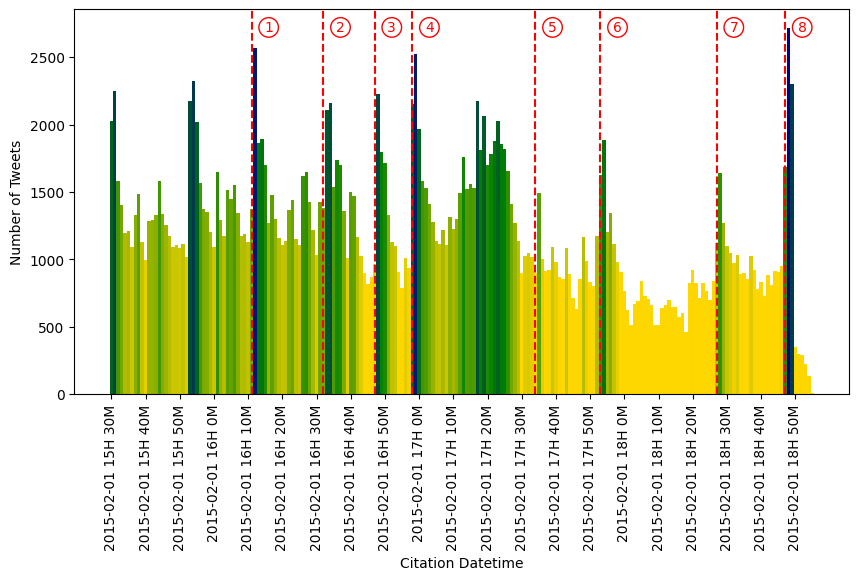

/tmp2/kch/ece219/ECE219_tweet_data/tweets_#gohawks.txt


/tmp/ipykernel_27643/2362341121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citation_date_datetime'] = df['citation_date'].apply(datetime.datetime.fromtimestamp, args=(pst_tz,))


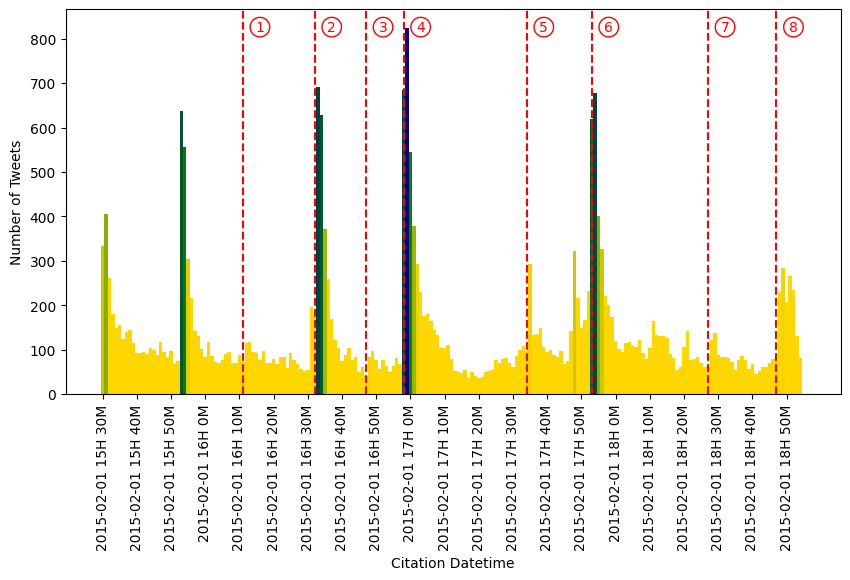

/tmp2/kch/ece219/ECE219_tweet_data/tweets_#nfl.txt


/tmp/ipykernel_27643/2362341121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citation_date_datetime'] = df['citation_date'].apply(datetime.datetime.fromtimestamp, args=(pst_tz,))


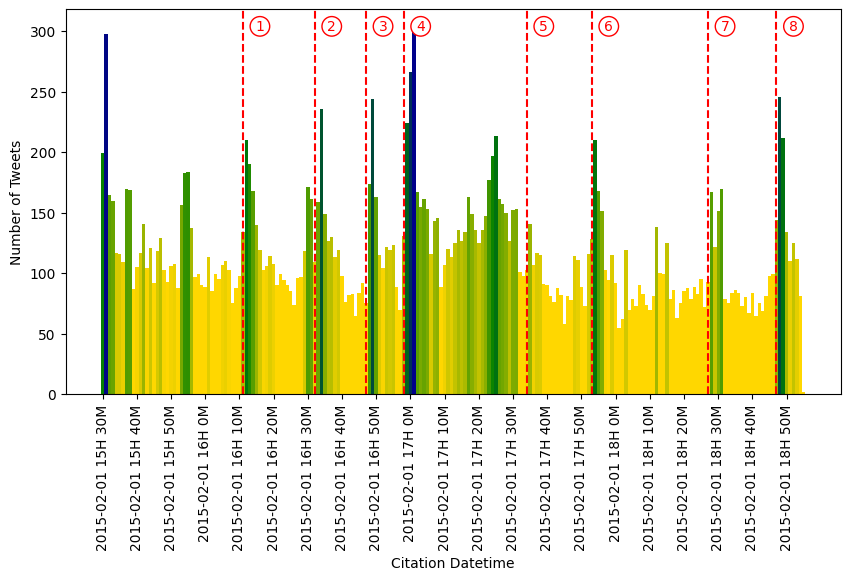

/tmp2/kch/ece219/ECE219_tweet_data/tweets_#gopatriots.txt


/tmp/ipykernel_27643/2362341121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citation_date_datetime'] = df['citation_date'].apply(datetime.datetime.fromtimestamp, args=(pst_tz,))


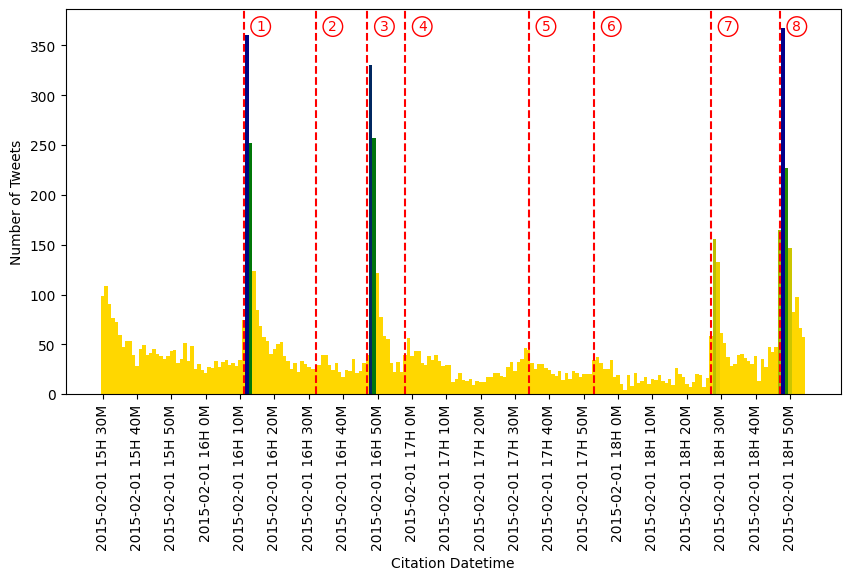

/tmp2/kch/ece219/ECE219_tweet_data/tweets_#patriots.txt


/tmp/ipykernel_27643/2362341121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citation_date_datetime'] = df['citation_date'].apply(datetime.datetime.fromtimestamp, args=(pst_tz,))


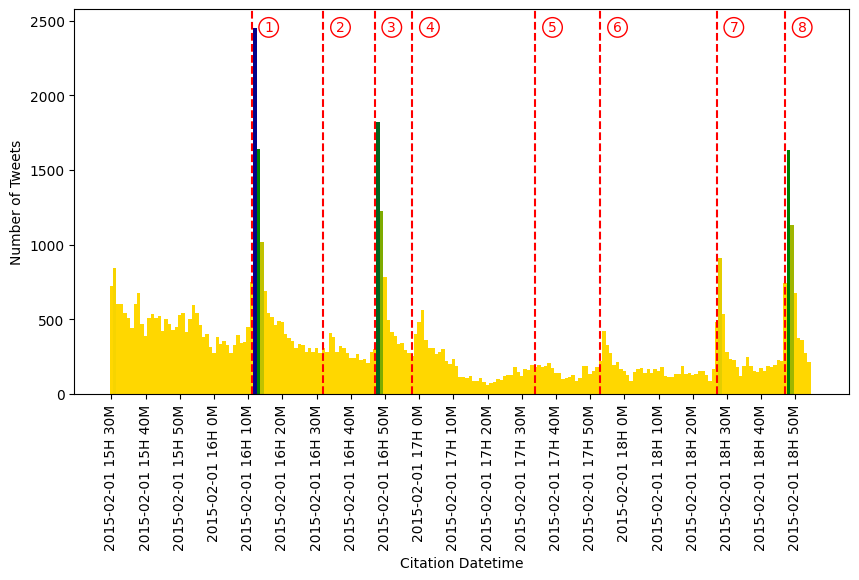

In [13]:
for filepath in filepaths:
    print(filepath)
    df = dataset_dict[filepath]
    df = df[(df['citation_date'] >= game_start) & (df['citation_date'] <= game_end)]
    df['citation_date_datetime'] = df['citation_date'].apply(datetime.datetime.fromtimestamp, args=(pst_tz,))
    tweets_per_minute_plot(df, 
                           title_prefix=filepath.split("#")[1][:-4])

In [14]:
data_dir = "/tmp2/kch/ece219/ECE219_tweet_data"
filename = "tweets_#gohawks.txt"
data = []
n = 100

with open(os.path.join(data_dir, filename)) as f:
    for line in tqdm(f):
        all_info = json.loads(line)
        # print(all_info["tweet"]["user"])
        taken_info = {
#             "type": all_info["type"],
#             # "title": all_info["title"],
            "text": all_info["tweet"]["text"],
            "id": all_info["tweet"]["id"],
#             "hashtags": " ".join([
#                 " ".join([s for s in re.split('([A-Z][a-z]+)', h["text"]) if s]) 
#                 for h in all_info["tweet"]["entities"]["hashtags"]
#             ]),  # hashtag split
            "location": all_info["tweet"]["user"]['location'],
#             "citation_date": all_info["citation_date"],
        }
        data.append(taken_info)

data_df = pd.DataFrame(data)

0it [00:00, ?it/s]

In [15]:
data_df

,text,id,location
0,I &lt;3 our defense! #GoHawks http://t.co/U1pc...,549327579782840320,Ontario
1,twelfth dogs are ready! #gohawks #dogslife htt...,549575600210718721,"Redmond, WA"
2,"""Oh no big deal, just NFC West Champs and the ...",549647876406534144,Seattle
3,At http://t.co/Vd0RWOeAed -- #Seahawks #12thMA...,549658771749101568,
4,"Good luck at Michigan, Jim Harbaugh. #GoHawks ...",549989186950803456,"Buffalo, Wyoming"
...,...,...,...
169117,How long to you think that it will be until we...,563946446702264320,Seattle
169118,"#Seahawks all day, everyday!!! #beastmode #LOB...",563952234178691072,"So. Cal,"
169119,Interview With the Seattle Seahawks Superbowl ...,563968915793903617,Washington
169120,If you love Russell Wilson and want to know mo...,563969561184460800,Seattle


In [16]:
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

from tqdm.auto import tqdm

# Used to map the twitter user location description to a standard format
def lookup_location(location, attempt=1, max_attempts=5):
    geo_locator = Nominatim(user_agent="LearnPython", timeout=None)
    try:
        location = geo_locator.geocode(location, language='en')
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return lookup_location(location, attempt=attempt+1)
        raise
    except:
        return
    return location

In [17]:
# data_df['map_location'] = data_df['location'].apply(lookup_location)

In [18]:
map_location = []
n = 0

In [19]:
try:
    for loc in tqdm(data_df['location']):
        # print(loc)
        map_location.append(lookup_location(loc))
        n += 1
        if n == 33000:
            break
except KeyboardInterrupt:
    pass

  0%|          | 0/169122 [00:00<?, ?it/s]

In [20]:
map_location

[Location(Ontario, Canada, (50.000678, -86.000977, 0.0)),
 Location(Redmond, King County, Washington, United States, (47.6694141, -122.1238767, 0.0)),
 Location(Seattle, King County, Washington, United States, (47.6038321, -122.330062, 0.0)),
 None,
 Location(Buffalo, Johnson County, Wyoming, 82834, United States, (44.3480865, -106.699287, 0.0)),
 Location(McChord Air Force Base, Fairway Road, Oakswest Apartments, Pierce County, Washington, 98438, United States, (47.1309548, -122.502686, 0.0)),
 Location(Washington, United States, (47.2868352, -120.212613, 0.0)),
 None,
 Location(Pacific Northwest College of Art - Schnitzer Center, 511, Northwest Broadway, Pearl District, Portland, Multnomah County, Oregon, 97209, United States, (45.5270896, -122.678128, 0.0)),
 None,
 None,
 None,
 None,
 None,
 Location(Washington, District of Columbia, United States, (38.8950368, -77.0365427, 0.0)),
 None,
 None,
 None,
 Location(Bellevue, King County, Washington, United States, (47.6144219, -122.19

In [21]:
lon = [x.longitude for x in map_location if x is not None ]
lat = [x.latitude for x in map_location if x is not None ]
temperature = [x.longitude for x in map_location if x is not None ]


In [22]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([lon,lat])
z = gaussian_kde(xy)(xy)


In [36]:
lower, upper = 0, 40

width = upper-lower
minn = min(z)
maxx = max(z)

l_norm = [(x - minn)/(maxx - minn) * width + lower for x in z]

/tmp/ipykernel_27643/2622752309.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['Low', "", "", "", '', "", "", 'High'])  # vertically oriented colorbar


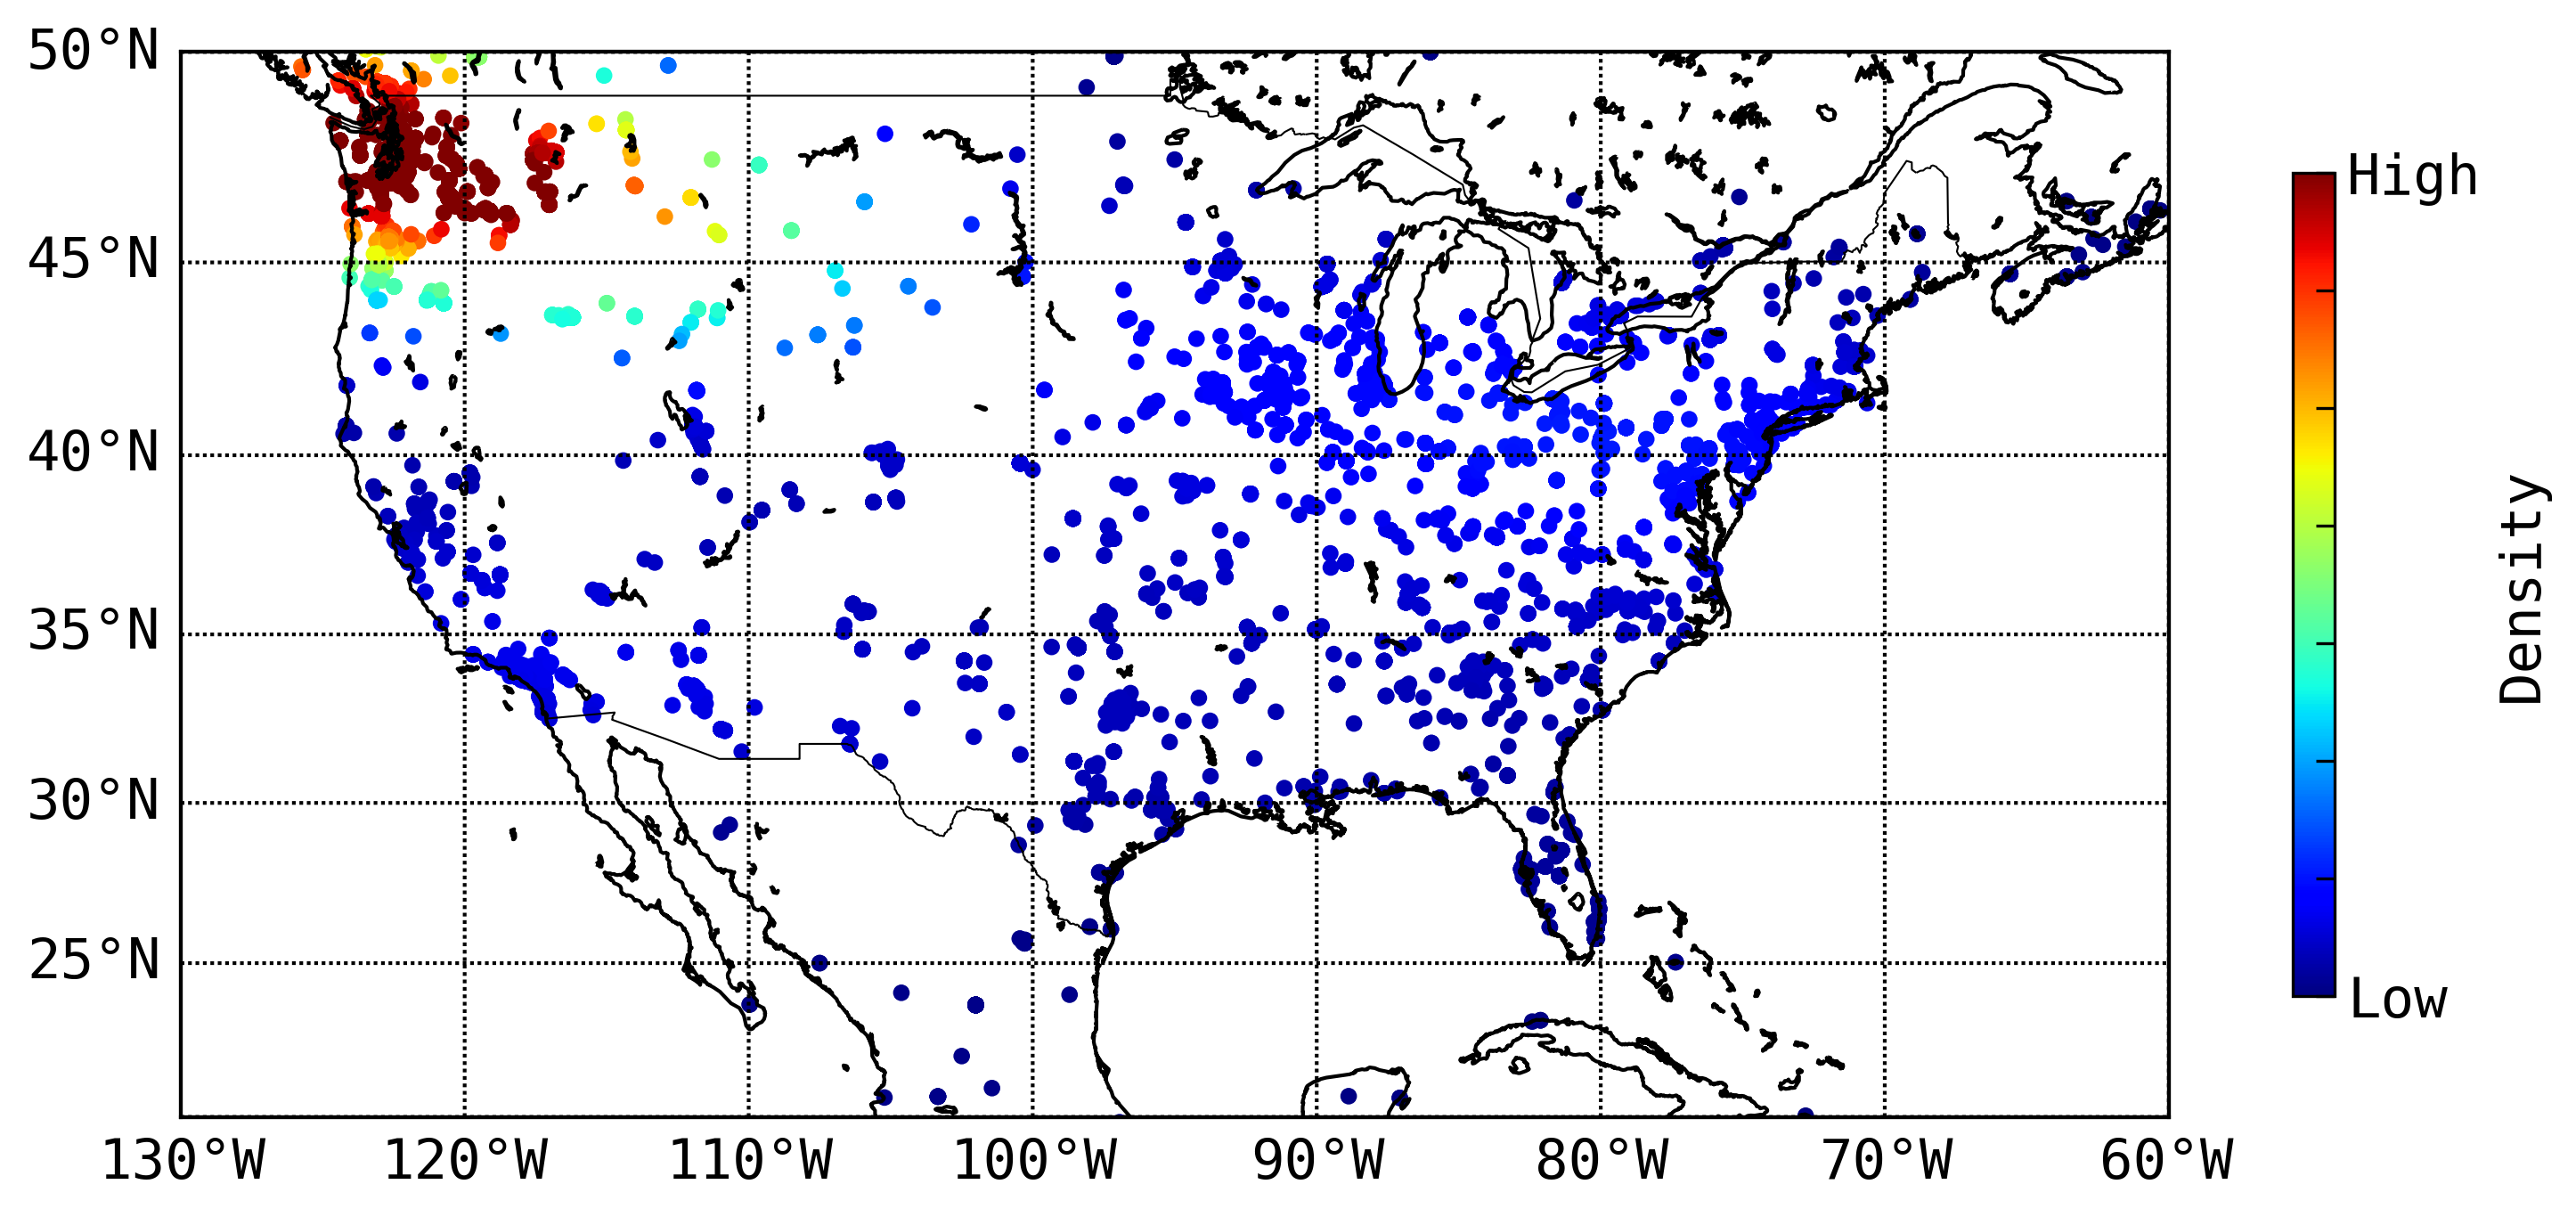

In [37]:
%matplotlib inline  
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# import numpy as np
from scipy.stats import gaussian_kde


m = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=50,\
            llcrnrlon=-130,urcrnrlon=-60,lat_ts=20,resolution='i')
m.drawcoastlines()
m.drawcountries()
# draw parallels and meridians.
parallels = np.arange(-90.,91.,5.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,10.)
m.drawmeridians(meridians,labels=[True,False,False,True])
m.drawmapboundary(fill_color='white')
# plt.title("Forecast {0} days out".format(day_out))
# Define a colormap
jet = plt.cm.get_cmap('jet')
# Transform points into Map's projection
x,y = m(lon, lat)
# Color the transformed points!
sc = plt.scatter(x,y, c=l_norm, vmin=0, vmax =35, cmap=jet, s=20, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5)
cbar.ax.set_yticklabels(['Low', "", "", "", '', "", "", 'High'])  # vertically oriented colorbar
cbar.set_label('Density')
plt.show()

In [25]:
len(lat)

20950

In [26]:
min(temperature)

-170.7131481

In [27]:
max(temperature)

178.1367523749267